# Introduction

This project explores machine learning methods to predict the popularity of reddit posts. Note that most explanations and interpretations are provided in the corresponding report. Our team is called TeamScholz and consists of Martin Scholz (11910748), Mark Tallai (01452456), Felix Gstettner (11810614) and Stepan Malysh (11929354). This code in this notebook starts by defining relevant functions that can be used for accessing and preprocessing the data and also for estimating models. The final section uses this functions to request the posts of r/elderscrollsonline and r/Atlanta. Next to the code chunks short explanations will be provided in markdown-cells. Note that this notebook focuses on defining the functions and running them on the corresponding subreddits. Explanations and interpretations can be found in detail in the report.

By using this notebook and the attached data you agree to comply with our privacy policy provided at https://github.com/hellfun1/Privacy_policy.

# Setting up Spark
As a first step, all required packages are imported and a spark session is initialized.

In [1]:
#import the required packages
#praw for connecting to the Reddit API
import praw
#import time to get the current time
import time
#import sys to get error messages
import sys
#note: we are aware of the fact that pandas is NOT scaleable. Pandas is only used as a helper function in order to get a local backup of our requested
#data. This was done to ensure reproducibility as the requested data depends on the exact time when the functions were called. Thus,
#to ensure reproducibility we added the data used for our analyses as csv-files to our submission. Exept from saving the data, pandas is NOT used for our algorithms.
import pandas
import math
from functools import reduce
#for plotting silhouette score:
import matplotlib.pyplot as plt

#load machine learning tools
# Import the StandardScaler Module to standardize feature vector
from pyspark.ml.feature import StandardScaler
#impport Vector Assembler to create feature vector
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import  Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml.feature import StringIndexer, VectorIndexer

#import functions from pyspark sql to replace/remove unneccessary words
from pyspark.sql import functions
#import the SparkSession module for using spark
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, array
from pyspark.sql.functions import translate
from pyspark.sql.functions import concat_ws, lit
from pyspark.sql.functions import struct    
from pyspark.sql.types import *
#import function to get the means
from pyspark.sql.functions import avg

from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

#for clustering we use KMeans
from pyspark.ml.clustering import KMeans

#import functions for models
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier

from  pyspark.ml import Pipeline

from pyspark.ml.functions import vector_to_array

In [2]:
# Build the SparkSession
spark = SparkSession.builder \
    .master("local") \
    .appName("Predicting Reddit Popularity") \
    .config("spark.executor.memory", "2gb") \
    .getOrCreate()

# Main entry point for Spark functionality. A SparkContext represents the
# connection to a Spark cluster, and can be used to create :class:`RDD` and
# broadcast variables on that cluster.      
sc = spark.sparkContext

# Collecting data and preprocessing
If needed the following code chunk installs the praw library. Note that we were required to install praw every time we restarted the server. Therefore, we decided to add this code chunk if an installation is needed. Only run the next code chunk if praw is not installed.

In [3]:
pip install praw

Note: you may need to restart the kernel to use updated packages.


### Defining the preprocessing function
The following functions start by opening a connection to the Reddit API. Next, the function requests the posts of a given subreddit. Furthermore, the functions also clean and preprocess the posts so the data can be used in the following steps. In fact, the youngest posts are omitted and several elements in the strings are removed. Rows containing missing values (for example the body would be empty if a post only contains a picture) are omitted.

In [6]:
###inputs
##subreddit: what subbreddit
##post_limit: how many posts should be fetched maximium of 1000
##max_age: maximum age of post in unix time units
###output:
##a pyspark data frame that contains our relevant data
def accessing(subreddit, post_limit, max_age):
    try:
        #establish connection to Reddit via the API
        reddit = praw.Reddit(client_id = 'client id',
                            client_secret = 'client secret',
                            username = 'username',
                            password = 'password',
                            user_agent = 'user agent')

        column_names = ["body" ,"unix_time", "num_comments", "score", "upvote_ratio"]
        
        #we first create a pyspark dataframe
        #to infer the schema, i.e. that there should be 6 columns with the correct data type
        #we specify some strings, integers and floats for the first row
        #the body is "#"
        #this string is later on replaced by an empty sting and later on the whole row is omitted
        #this is an in-between step that helps saving the data in a pyspark dataframe
        data_DF = spark.createDataFrame([("#",100,100,100,0.5)], column_names)
        
        #access the data about the posts
        for sub in reddit.subreddit(subreddit).new(limit=post_limit):
            new_post = spark.createDataFrame([(sub.selftext, sub.created_utc, sub.num_comments, sub.score, sub.upvote_ratio)], column_names)
            data_DF = data_DF.union(new_post)


        #examine schema:
        #note that the following code line would show that there is no problem regarding the data types
        #i.e., numeric values are represented as either floats or strings, characters are correctly saved as string
        #data_DF.printSchema()
        #thus, there is no need to convert data types, they were identified correctly each time we ran the code
        #note that we tried this out with different subreddits and the schema was correctly identified in each case
        
        #exclude the youngest posts
        # get the time
        time = time.time()
        #filter out young posts
        data_DF = data_DF.filter(time - data_DF.unix_time>= max_age)#86400 is one day

        #clean the text of the posts
        #more cleaning will be done in the preprocessing-function later on
        #replace missing values with "None"
        data_DF = data_DF.na.replace('', None)
        
        #removing commas and paragraphs is especially important if the data is saved locally as a csv-file
        #as we are providing a hard save of our used data, commas and paragraphs in the body will lead to messy results when the csv is read into
        #a pyspark dataframe. Thus omitting them before the local save ensures that the data is stored correctly and could be used without further issues
        #remove commas
        data_DF = data_DF.withColumn('body', functions.regexp_replace('body', ',', ''))
        #remove paragraphs
        data_DF = data_DF.withColumn('body', functions.regexp_replace('body', '\n', ''))
        
        #drop missing values
        data_DF = data_DF.na.drop()
        
        return data_DF
    
    except:
        #troubleshooting:
        #check if given argument is string
        if (isinstance(subreddit, str) == False):
            print("Error: Argument must be a string.")
        else:
            #get other error messages
            #might be, e.g., that a given Subreddit does not exist
            #which will give either a 404 HTTP error (i.e. "not found")
            #or a message that the request was redirected to the search page (e.g., if the given subreddit does not exist)
            #note that there might also occur a SparkException Error that may arise because the dataframe is empty,
            #i.e., there are no observations left (this might occur if the time threshold for youngest posts is too big compared to the age of the oldest post)
            print("Unexpected error:", sys.exc_info()[1])

In [7]:
###inputs:
##subreddit: what subbreddit
##post_limit: how many posts should be fetched, this is limited by Reddit to approximately 1000 posts 
##max_age: maximum age of post in unix time units
###output:
##a pyspark data frame that contains our relevant data
def preprocessing(df):
    try:
        #data preprocessing:
        data_DF = df

        #clean posts:
        #remove expressions based on seuggestions made in the lab sessions
        data_DF = data_DF.withColumn('body', functions.regexp_replace('body', r'http\S+', ''))
        data_DF = data_DF.withColumn('body', functions.regexp_replace('body', '#', ''))
        data_DF = data_DF.withColumn('body', functions.regexp_replace('body', ':', ''))
        data_DF = data_DF.withColumn('body', functions.regexp_replace('body', ';', ''))
        data_DF = data_DF.withColumn('body', functions.regexp_replace('body', r'\n', ''))
        data_DF = data_DF.withColumn('body', functions.regexp_replace('body', r'\*', ''))
        #remove mentioned user names in posts
        #note that there are two ways on Reddit to link users, /u and /u/
        data_DF = data_DF.withColumn('body', functions.regexp_replace('body', r'/u/+', ''))
        data_DF = data_DF.withColumn('body', functions.regexp_replace('body', r'u/+', ''))
        #remove zero-width space
        data_DF = data_DF.withColumn('body', functions.regexp_replace('body', r'&x200B', ''))

        #drop missing values
        data_DF = data_DF.na.drop()

        #collect the relevant variables for clustering in a single column called features
        #clustering will be based on the number of comments, score and the upvote ratio
        vecAssembler = VectorAssembler(inputCols=["num_comments", "score", "upvote_ratio"], outputCol="features")
        data_DF_fea = vecAssembler.transform(data_DF)

        # Standardizes features by removing the mean and scaling to unit variance using column summary
        # statistics on the samples in the training set.
        standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")

        # Fits a model to the input dataset with optional parameters.
        scaler = standardScaler.fit(data_DF_fea)

        # Transforms the input dataset with optional parameters.
        DF_scaled = scaler.transform(data_DF_fea)

        #return the preprocessed spark dataframe
        #and print the remaining number of observations
        print("The cleaned dataframe consists of "+ str(DF_scaled.count()) + " observations.")
        return DF_scaled
    
    except:
        #troubleshooting:
        #get error messages
        #note that there might also occur a SparkException Error that may arise because the the dataframe is empty,
        #i.e., there are no observations left
        print("Unexpected error:", sys.exc_info()[1])

## Clustering

The following section defines functions that are used for clustering. Clustering is based on the collected metadata (number of comments, score and upvote ratio). We are going to use the K-means method. The first function, get_K(), uses the silhouette score to find out the optimal number of clusters K. The second function, cluster(), uses the optimal number of clusters obtained by the previous function to cluster the data based on the respective metadata. Note that we restricted the possible values for K to lie between 3 and 10. The lower boundary ensures that for a given dataframe there exist some clusters. The upper boundary is limited to 10 in order to limit computational time. While a higher number of clusters might be more optimal, K-means clustering has the big disadvantage that it is time-consuming. In our case, clustering is running eight times (once for each possible value of K). The higher K, the higher the overall computational time. Therefore, K is limited to 10. The code regarding clustering was partly adapted from https://rsandstroem.github.io/sparkkmeans.html. Please note that until now we have defined a try and except statement to ensure error handling. This will be not included in any of the following functions as there should not be any problems if the correct dataframe is given as input.

In [8]:
def get_K(df):
    # get optimal K for K means clustering
    #output will be a plot based on silhouette score
    #which can be used to find out the optimal number of clusters K
    try:
        #create evaluator
        #we are going to use the silhouette score based on a squared euclidean distance measure
        evaluator_sil = ClusteringEvaluator(predictionCol='prediction', featuresCol='features_scaled', metricName='silhouette', distanceMeasure='squaredEuclidean')    

        #compute "cost" for different K
        #we try out values from 3 to 10
        #set seed for reproducibility
        score = []
        for k in range(3,10):
            #note that this for loop is one of the most time consuming parts of the code
            #get model for clustering
            kmeans = KMeans().setK(k).setSeed(123).setFeaturesCol("features_scaled")
            #assign clusters to observations
            model = kmeans.fit(df)
            #assign observations to group
            output = model.transform(df)
            #compute cost
            eval_score = evaluator_sil.evaluate(output)
            score.append(eval_score)

        #plot the silhouette score
        plt.plot(range(3,10), score)

        #we choose K such that the silhouette score is maximized
        #note that we have to add 3 as the index starts at 0 but possible values for K at 3
        print("Based on the silhoutte score, the optimal number of clusters is " + str(score.index(max(score))+3) +".")
    except:
        #troubleshooting
        #this deals e.g. with the situation if a string or float element is given instead of a dataframe
        print("Unexpected error:", sys.exc_info()[1])

In [9]:
def cluster(df, K):    
    try:
        #get final clustering
        kmeans = KMeans().setK(K).setSeed(123).setFeaturesCol("features_scaled")
        model = kmeans.fit(df)
        df_clu = model.transform(df)
        #rename  prediction column to label
        df_clu = df_clu.withColumnRenamed("prediction","label")
        return df_clu
    except:
        #troubleshooting
        #this deals e.g. with the situation if a string or float element is given instead of a dataframe
        print("Unexpected error:", sys.exc_info()[1])


## Decision trees

A decision tree model is based on a tree-like structure. Each node represents one test. Depending on whether the test is successful or not, one of the child nodes is being tested. The final nodes of each path represent predictions. The following code was adapted from https://spark.apache.org/docs/latest/ml-classification-regression.html#decision-tree-classifier and from https://github.com/Jcharis/pyspark-tutorials .

In [11]:
def getPrediction(trainingData, testData):
    tokenizer = Tokenizer(inputCol = 'body',outputCol = 'body_toc') # converting the body into tokens
    stopwords_remover = StopWordsRemover(inputCol = 'body_toc',outputCol = 'body_toc_filtered') # removing stopwords
    vectorizer = CountVectorizer(inputCol = 'body_toc_filtered', outputCol = 'body_raw_features') # vectorising the words
    idf = IDF(inputCol='body_raw_features', outputCol='body_vectorized_features') #getting the inverse document freqeuncy of the tokens
    dt = DecisionTreeClassifier(featuresCol = 'body_vectorized_features', labelCol = 'label', maxDepth = 6) # we apply Decision tree classifier model to predict the label by body column
    dt_pipeline = Pipeline(stages = (tokenizer,stopwords_remover,vectorizer,idf,dt)) # we create a pipeline for decision tree
    
    modeldt = dt_pipeline.fit(trainingData)#We train the model on the training data, which is 70% of the dataset, randomly chosen
    predictions = modeldt.transform(testData)#We make predictions on the test data, which is 30% of the dataset, randomly chosen
    #finally we only return relevant columns of the resulting dataframe
    predictions = predictions.select("body","num_comments","score","upvote_ratio","features","features_scaled","prediction", "rawPrediction")
    return predictions

## Logistic regression

The second machine learning model that is applied in this project is logistic regression. Logistic regression predicts the probability whether an observation belongs to a specific cluster or not. In general, logistic regression can only predict the probability if two clusters exists (as logistic regression eventually predicts True-or-False outputs given some probability threshold for True events). In our case there exist more than two clusters. Therefore, the logistic regression model has to be adapted, so the model can be used in a multiclass environment. In short, the algorithm predicts the probabilities whether a post belongs into each individual cluster. The cluster with the highest probability is then chosen as final prediction. For more details, please see the corresponding section in the report. The code was partly adapted from https://towardsdatascience.com/machine-learning-with-spark-f1dbc1363986 and https://github.com/Jcharis/pyspark-tutorials.

The first few codechunks are preparing the data for logistic regression and estimate the probability that a post belongs to each individual cluster. The next section defines a function that determines the final prediction based on the highest estimated probability.

In [14]:
####used to split the label up so it can be used for logistic regression
###inputs
##DF_train is the the clustered data frame
## clusters is the number of clusters
###outputs
##DF_train is the clustered data frame prepared for logistic regression
def createLabelingForLogistics(DF_train,clusters):
    cluster_str = "" 
    empty_str = "" 
    for j in range(0,clusters): 
        cluster_str += str(j) #creates a string 123...  for which length = number of clusters
        empty_str += '0' # creats a str with length = number of clusters and then fills that string with 0
    for  i in range(0,clusters):
        true_list = list(empty_str) 
        true_list[i] = '1' # adds a 1 to postion i in the true string so it can be correctly  put int the labels 
        true_str = ''.join(true_list)
        DF_train = DF_train.withColumn("label"+str(i), translate('label', cluster_str ,true_str ).cast('float'))  # uses the translate method to assign 1 or 0 to the label columns 
        #depending on its label 
    return DF_train

In [15]:
####creates the pipeline for predicting
###input:
##label_name ... the name of the column that should be predicted
###output:
##lr_pipline the pipeline for the logistic regression
def createPipeline(label_name):
    tokenizer = Tokenizer(inputCol = 'body',outputCol = 'body_toc') # splitting the body into words
    stopwords_remover = StopWordsRemover(inputCol = 'body_toc',outputCol = 'body_toc_filtered') # removing stopwords
    vectorizer = CountVectorizer(inputCol = 'body_toc_filtered', outputCol = 'body_raw_features') # vectorising the words
    idf = IDF(inputCol='body_raw_features', outputCol='body_vectorized_features') #getting the inverse document frequncy of the words
    lr = LogisticRegression(featuresCol = 'body_vectorized_features', labelCol = label_name ) #train the logistic regression model
    lr_pipeline = Pipeline(stages = (tokenizer,stopwords_remover,vectorizer,idf,lr))
    return lr_pipeline

In [16]:
####takes the data and estimates the models and predicts the outcome for the test data
###inputs:
##trainDF = the training data
##testDF = the testing data
##clusters = the amount of clusters
###outputs:
## the test dataframe with the predictions

def getModelPredictions(trainDF,testDF,clusters):
    lr_models = []
    columns = StructType([])
    lr_predictions=[]
    for i in range(0, clusters):
        label_name="label"+str(i) # getting the name of the label to predict
        lr_pipeline = createPipeline(label_name) # making the pipeline
        lr_models.append(lr_pipeline.fit(trainDF)) # getting the model

        lr_predictions.append(lr_models[i].transform(testDF)) #getting the predictions
        
        #renaming the columns
        lr_predictions[i] = lr_predictions[i].withColumnRenamed("RawPrediction","RawPrediction"+str(i))
        lr_predictions[i] = lr_predictions[i].withColumnRenamed("probability","probability"+str(i))
        lr_predictions[i] = lr_predictions[i].withColumnRenamed("prediction","prediction"+str(i))
        if i > 0 :
            lr_predictions[0] = lr_predictions[0].join(lr_predictions[i],lr_predictions[0].columns[0 : - 3 * i],'inner') # joining with the fist prediction so 
            #everything is in the same df
    return lr_predictions[0]

### Combining the predictions into one final prediction

This is done by choosing the category that was predicted with the highest probability

In [17]:
####chooses the overall prediction for each post
### inputs:
## prediction_list ... the probabilities
###output:
## the predicted outcome

def select_final_prediction_udf(prediction_list):
    probability = 0
    counter = 0
    label = 0
    for prediction in prediction_list:
        if prediction[1] >= probability:
            label = counter
            probability = prediction[1]
        counter+=1

    return label
    
select_final_prediction = spark.udf.register("final_prediction", select_final_prediction_udf) # registers select_final_orediction as a udf with spark, meaning that it can be used
# to select the best prediction for each line in a dataframe

####choses the overall prediction
### inputs:
## results ... the results of the separate logistic predictions as dataframe
## testDF ... the test data as a dataframe
###output: the final results of the lr as dataframe
def make_final_prediction_column(results, testDF):
    column_list = results.columns[len(testDF.columns)+4:-1] # get the list columns that were added by the prediction
    selected_column_list = []
    counter = -1
    for i in column_list: # get the list of probability columns
        if counter % 3 == 0:
            selected_column_list.append(i)
        counter+=1
        
    #use the list of probabilty columns to get the final probability
    lr_results_df = results.withColumn("final_prediction", select_final_prediction(array(selected_column_list)))
    
    return lr_results_df

In [18]:
#this is the final function of the logistic regression model
#for applying the logistic regression model only this function has to be called
#the functions above are helper functions that are called inside this final function.
####run lr prediction
###Inputs
##trainDF ... training data
##testDF ... testing Data
##clusters ... number of clusters
###output:
## dataframe of test data with all the prediction outcomes
def lr_prediction(trainDF, testDF, clusters):
    trainDF_lr = createLabelingForLogistics(trainDF, clusters) #split the label to prepare the training data for logistic regression
    results = getModelPredictions(trainDF_lr,testDF, clusters) # estimate the logistic regression model and get estimated probabilites
    return make_final_prediction_column(results, testDF) #make the final predictions and return the test dataframe with the predicted clusters

## Computing the distance to assess model accuracy

As argued later in this notebook and in more detail in the report, we cannot rely on accuracy, or false or true positives because the collected data is missing a label. The label (i.e., the cluster) is determined by the algorithm. Therefore, the test data has no label assigned to it and many metrics cannot be used efficiently. Thus, we decided to compare the models obtained by logistic regression and decision trees based on the Euclidean distance between the true scaled values of the features (number of comments, score and upvote ratio) and the mean values of the corresponding predicted cluster. Finally, these distances are summed up. This measurement can be used to compare the efficiency of two or more models. The lower the distance measurement the better the model.

In [87]:
####get the position means of the labels
###inputs 
##clu ... the clustered data frame
##K the number of clusters
###output 
## a nested list containing the coordinates of the label means
def get_labal_position_means(clu,K):
    positions = []
    for i in range(K): 
        features_scaled_df = clu.select("features_scaled").where(clu.label == i)
        features_scaled_df = features_scaled_df.withColumn("scaled", vector_to_array("features_scaled")).select(["features_scaled"] + [col("scaled")[j] for j in range(3)]) #unpass the scaled features column
        position = []
        position.append(features_scaled_df.agg({'scaled[0]':'mean'}).select("avg(scaled[0])").collect()[0][0]) #calculates the mean for num_comments
        position.append(features_scaled_df.agg({'scaled[1]':'mean'}).select("avg(scaled[1])").collect()[0][0])
        position.append(features_scaled_df.agg({'scaled[2]':'mean'}).select("avg(scaled[2])").collect()[0][0])
        positions.append(position)
    return positions

In [88]:
####get the distance between the label means and the imput row
###input 
##input ...  an array of columns containg the necessary position arguments
###output
##the distance between the label means and the input row
def get_distance_udf(imput):
    for i in range(len(imput)):
        imput[i]=float(imput[i])
    distance = math.sqrt((imput[0]-imput[3])**2+(imput[1]-imput[4])**2+(imput[2]-imput[5])**2)
    return distance
get_distance= spark.udf.register("distance", get_distance_udf)

In [89]:
####makes a data frame that contains a distance measurement from the row to the label mean
###inputs
##clu ... clustered dataframe
##results ... dataframe with the results of clustering
##K ... number of clusters
##prediction_column_name ...  the name of the column that gets predicted
###output
##a dataframe with the distance and other relevant results

def make_distance_column(clu,results, K, prediction_column_name):
    positions = get_labal_position_means(clu,K)
    ####gets the first coordinate of the position of predicted cluster
    ###inputs
    ##label ... wich cluster has been predicted
    ###output
    ##the first coordinate of the predicted cluster
    def get_position_0_udf(label):
        return positions[label][0] #position is using the outer variable
    get_position_0 = spark.udf.register("label_pos_0", get_position_0_udf) # registering as udf for use with pyspark
    ####gets the second coordinate of the position of predicted cluster
    ###inputs
    ##label ... which cluster has been predicted
    ###output
    ##the second coordinate of the predicted cluster
    def get_position_1_udf(label):
        return positions[label][1]
    get_position_1 = spark.udf.register("label_pos_1", get_position_1_udf)
    ####gets the third coordinate of the position of predicted cluster
    ###inputs
    ##label ... which cluster has been predicted
    ###output
    ##the third coordinate of the predicted cluster
    def get_position_2_udf(label):
        return positions[label][2]    
    get_position_2 = spark.udf.register("label_pos_2", get_position_2_udf)
    
    results_lp = results.withColumn("label_pos_0", get_position_0(col(prediction_column_name))) # get the first coordinate of the position of predicted cluster
    results_lp = results_lp.withColumn("label_pos_1", get_position_1(col(prediction_column_name))) # get the second coordinate of the position of predicted cluster
    results_lp = results_lp.withColumn("label_pos_2", get_position_2(col(prediction_column_name)))# get the third coordinate of the position of predicted cluster
    results_lp = results_lp.withColumn("scaled", vector_to_array("features_scaled")).select(["body"] # prepare the right columns and devectorise features_scaled
                                            + ["num_comments"] + ["score"] + ["upvote_ratio"] + [prediction_column_name]
                                            + ["label_pos_0"] + ["label_pos_1"]+ ["label_pos_2"]+["features_scaled"] + 
                                            [col("scaled")[j] for j in range(3)]) 
    results_lp = results_lp.withColumn("distance", get_distance(array(col("label_pos_0"), col("label_pos_1"), col("label_pos_2"), col("scaled[0]"),col("scaled[1]"),col("scaled[2]")))) # get the distances form the cluster mean
    results_lp = results_lp.drop("label_pos_0", "label_pos_1", "label_pos_2", "scaled[0]", "scaled[1]", "scaled[2]") # drop some unnecessary columns
    return results_lp

# Analyzing subreddits

This section analyzes the chosen subreddits, r/elderscrollsonline and r/Atlanta. Both subreddits might be relevant for marketing departments. Reddit posts could be used for promoting the Elder Scrolls Online video game or the city Atlanta. For such a promotion it is important to write a post that achieves as much attention (as upvotes and number of comments) as possible. This section explores whether it is possible to use logistic regression and decision trees to achieve predictions whether a post in the specific subreddit may get the required attention.

## Accessing the data
In a first step we access the data from r/elderscrollsonline and r/Atlanta. The accessing-function also removes the youngest posts (we excluded all posts that were uploaded in the last 24 hours).

In [16]:
df_eso = accessing("elderscrollsonline",1000, 86400)

In [20]:
df_atlanta = accessing("Atlanta",1000, 86400)

### Save the data locally
The function above returns different data depending on the exact time (the data that is used in our analysis was collected on February 5th 2022 at approximately 22:00) the function was called. Therefore, to make results reproducible, we decided to add a csv-file of the respective data in our final submission. The next two code chunks save the dataframes locally. In order to easily save the data we are going to use pandas. While pandas itself is not scalable, this section is only included in order to make results more reproducible and all further steps will be done with a pyspark-dataframe (which again is scalable). The pandas-dataframes are only used to store the data locally and make results reproducible. Pandas should not be used for huge amount of data. Note that if the accessing functions above are called, there is no need to run this section. This section serves only to ensure reproducibility.

In [17]:
df_eso.toPandas().to_csv('df_eso.csv', index=False)

In [21]:
df_atlanta.toPandas().to_csv("df_atlanta.csv", index=False)

The next codechunks might be used to load the locally stored csv-files into a pyspark dataframe.

In [19]:
df_eso = spark.read.csv('df_eso.csv', header=True, sep=",", inferSchema='True')

In [20]:
df_atlanta = spark.read.csv("df_atlanta.csv", header=True, sep=",", inferSchema='True')

### Clean and preprocess the data
Now, the collected data is cleaned and preprocessed. Some expressions are removed from the body. Finally, the explanatories are standardized so they can be used for clustering. After preprocessing the data, there are 754 observations about Elder Scrolls Online and 716 posts about Atlanta left.

In [21]:
df_eso = preprocessing(df_eso)

The cleaned dataframe consists of 754 observations.


In [22]:
df_atlanta = preprocessing(df_atlanta)

The cleaned dataframe consists of 716 observations.


## Clustering

Now the optimal number of clusters is determined. In the next step, the training data is clustered based on the optimal number of clusters determined by the maximum of the silhoutte score.

In [23]:
# Split the data into training and test sets (30% held out for testing)
# note that for reproducibility we set the seed to 234
(training_eso, test_eso) = df_eso.randomSplit([0.7, 0.3], 234)

In [24]:
(training_atlanta, test_atlanta) = df_atlanta.randomSplit([0.7, 0.3], 234)

Based on the silhoutte score, the optimal number of clusters is 3.


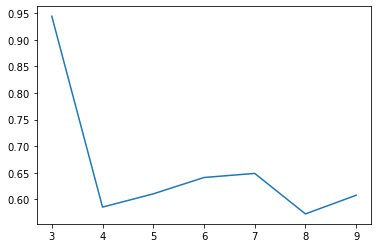

In [25]:
get_K(training_eso)

Based on the silhoutte score, the optimal number of clusters is 8.


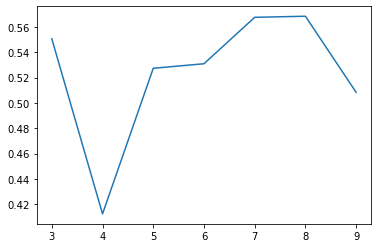

In [26]:
get_K(training_atlanta)

In [28]:
K_eso = 3
clu_eso = cluster(training_eso, K_eso)

In [29]:
K_atlanta = 8
clu_atlanta = cluster(training_atlanta, K_atlanta)

Now we have a look at the clustered data. First we check how many posts are assigned to each individual cluster.\
For r/elderscrollsonline nearly all observations are assigned to cluster 0. This implies, that nearly all collected posts from r/elderscrollsonline are similar in terms of score, upvote ratio and number of comments. The ten comments that are not located in cluster 0 might be outliers. This certainly leads to bias. This can be seen too in a later section where this data is used for estimating the models.\
For r/Atlanta the clustering looks better. The data is grouped into eight different clusters. However, there are still some clusters (in fact cluster 2, 5 and 7) that only contain a handful of observations. In the case of r/Atlanta this could imply that these posts are outliers (in terms of the metadata). It could, however, also be the case that these results from the fact that the sample size is quite low. Both cases might lead to biased and inconsistent results of the predictions.

In [33]:
clu_eso.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|    1|
|    2|    9|
|    0|  502|
+-----+-----+



In [34]:
clu_atlanta.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   52|
|    6|  154|
|    3|  212|
|    5|    1|
|    4|   22|
|    7|    2|
|    2|    3|
|    0|   49|
+-----+-----+



The clustering method applied above automatically labels the clusters with integers (ranging from 0 to the total number of clusters). Now, let us look at the cluster means (i.e., the mean values of the number of comments, score and upvote ratio of each cluster). Note that the following code was adapted from https://stackoverflow.com/questions/36251004/pyspark-aggregation-on-multiple-columns .\
For r/elderscrollsonline our presumption that the observations of cluster 1 and 2 are outliers is supported by the following results. The majority of posts has an average number of comments of 12.62, an average score of 5.02 and an upvote ratio of 72.5%. While the three clusters do not differ that much in terms of the upvote ratio there are huge differences regarding the number of comments and the score. The post of cluster 1 has a significnat higher number of comments and score than the average post in cluster 0. As the project aims at predicting popularity (which could also be seen as attention) the clusters of r/elderscollsonline could be sorted from least popular to most popular: cluster 0, cluster 2, cluster 1.\
r/Atlanta has a similar situatio as r/elderscollsonline. The majority of posts is located in clusters that have a relatively low number of comments and score. Five observations, however, have really high values. To remark, this might indicate the presence of outliers or that the sample size is too small.

In [46]:
#group the clustered data by label and get the average number of comments, score and upvote ratio.
#for r/elderscollsonline:
clu_eso.groupBy("label").agg(avg("num_comments"), avg("score"), avg("upvote_ratio")).show()

+-----+------------------+------------------+------------------+
|label| avg(num_comments)|        avg(score)| avg(upvote_ratio)|
+-----+------------------+------------------+------------------+
|    1|             454.0|             478.0|              0.77|
|    2|135.88888888888889|245.44444444444446|              0.88|
|    0|12.615537848605578|5.0239043824701195|0.7254382470119528|
+-----+------------------+------------------+------------------+



In [47]:
#for r/elderscollsonline:
clu_atlanta.groupBy("label").agg(avg("num_comments"), avg("score"), avg("upvote_ratio")).show()

+-----+------------------+------------------+------------------+
|label| avg(num_comments)|        avg(score)| avg(upvote_ratio)|
+-----+------------------+------------------+------------------+
|    1|16.115384615384617| 4.596153846153846|0.5384615384615383|
|    6|14.551948051948052| 9.909090909090908|0.7481818181818181|
|    3| 20.64622641509434| 23.67924528301887|0.8960377358490562|
|    5|             182.0|             544.0|              0.94|
|    4| 86.68181818181819|124.36363636363636|0.9131818181818182|
|    7|             301.5|             325.5|0.9550000000000001|
|    2|             306.0|             170.0|0.9533333333333333|
|    0|131.20408163265307|  22.3265306122449|0.8981632653061222|
+-----+------------------+------------------+------------------+



## Logistic regression

The clustered training data is now used to train a logistic regression model. Secondly, the model predicts the cluster of the observations in the test data.

In [48]:
eso_results_lr = lr_prediction(clu_eso, test_eso, K_eso)

In [49]:
atlanta_results_lr = lr_prediction(clu_atlanta, test_atlanta, K_atlanta)

For r/elderscrollsonline most posts are predicted to lie in cluster 0. This confirms the argumentation in the section about clustering. Most training data is labeled as cluster 0. Therefore, one would suspect that the majority of the test data is predicted to be in cluster 0. There are not enough observations loacted in cluster 1 and 2 to consistently estimate a model. This result is not very appealing.

In [50]:
eso_results_lr.groupBy("final_prediction").count().show()

+----------------+-----+
|final_prediction|count|
+----------------+-----+
|               0|  241|
|               2|    1|
+----------------+-----+



For r/Atlanta the predictions are more varied across the different clusters. Without running further model diagnostics, it seems that the logistic regression model (together with the collected data) is more useful for predicting the popularity of posts about Atlanta than for Elder Scrolls Online.

In [52]:
atlanta_results_lr.groupBy("final_prediction").count().show()

+----------------+-----+
|final_prediction|count|
+----------------+-----+
|               7|    6|
|               3|   58|
|               0|   25|
|               5|   14|
|               6|   26|
|               1|   36|
|               4|   48|
|               2|    8|
+----------------+-----+



## Decision trees

This section applies the decision tree method. First, the model is trained and, secondly, the clusters of the posts in the test set are predicted.

In [53]:
eso_results_dt = getPrediction(clu_eso, test_eso)

In [54]:
atlanta_results_dt = getPrediction(clu_atlanta, test_atlanta)

For r/elderscrolls the decision tree model returns similar predictions as logistic regression. The majority of posts seems to be located in the most unpopular cluster.

In [55]:
eso_results_dt.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  240|
|       2.0|    2|
+----------+-----+



The decision tree model returns interesting estimates for r/Atlanta. First of all, note that observations of the test data are predicted to lie in only five out of eight clusters. The missing clusters are 2,5 and 7. These are exactly the clusters that do not have much observations in the training set. Secondly, estimates obtained for r/Atlanta by Decision trees are different to the ones obtained by logistic regression. This will be discussed in more detail in the next section.

In [56]:
atlanta_results_dt.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|   25|
|       1.0|    1|
|       4.0|    1|
|       3.0|   39|
|       6.0|  155|
+----------+-----+



## Comparing the model

In general, one would run several model diagnostics in order to assess whether a model predicts accurate or not. The problem is that most methods require to know the true label of the test data. This project collects the data without any label and assigns the label to the training set by clustering methods. This means that there is no efficient way to assign the true labels to the test data. Because of that, several methods such as accuracy, true and false positives or ROC cannot be applied. \
First, we will compare the predictions of the two models depending on the subreddit.

In [ ]:
#r/elderscrollsonline
y = 0
for i in range(eso_results_dt.count()):
    if (eso_results_dt.select("prediction").collect()[i][0] == int(eso_results_lr.select("final_prediction").collect()[i][0])):
        y += 1

In [79]:
y/eso_results_dt.count()

0.987603305785124

In [75]:
#r/Atlanta
x = 0
for i in range(atlanta_results_dt.count()):
    if (atlanta_results_dt.select("prediction").collect()[i][0] == int(atlanta_results_lr.select("final_prediction").collect()[i][0])):
        x += 1

In [80]:
x/atlanta_results_dt.count()

0.2398190045248869

Secondly, we will compare the accuracy of the two models based on the distance between the true values (the standardized values of number of comments, score and upvote ratio) and the mean values of the predicted clusters. Mathematically, this computes the distance for each observation (which can be seen in our case as a point in a three dimensional space) and its corresponding center mean. Secondly it sums up the distances. The distance itself does not give that much information. It can, however, be used to compare two or more models. The lower the sum of the distances the better are the predictions.

In [103]:
#compute the distance measurement for r/elderscrollsonline obtained by logistic regression
is_eso_lr = make_distance_column(clu_eso, eso_results_lr, K_eso, "final_prediction")
dis_eso_lr.agg({'distance': 'sum'}).show()

+-----------------+
|    sum(distance)|
+-----------------+
|273.4167650769202|
+-----------------+



In [104]:
#compute the distance measurement for r/elderscrollsonline obtained by decision trees
dis_eso_dt = make_distance_column(clu_eso, eso_results_dt.withColumn("prediction", eso_results_dt.prediction.cast("int")), K_eso, "prediction")
dis_eso_dt.agg({'distance': 'sum'}).show()

+------------------+
|     sum(distance)|
+------------------+
|290.43315429333927|
+------------------+



For r/elderscrollsonline the distance measurement is not that much different. This is supported by the fact that over 90% of all predictions are the same for both models. Both models estimate equally well.

In [92]:
#compute the distance measurement for r/atlanta obtained by logistic regression
dis_atlanta_lr = make_distance_column(clu_atlanta, atlanta_results_lr, K_atlanta, "final_prediction")
dis_atlanta_lr.agg({'distance': 'sum'}).show()

+-----------------+
|    sum(distance)|
+-----------------+
|671.0777058893595|
+-----------------+



In [102]:
#compute the distance measurement for r/atlanta obtained by decision trees
dis_atlanta_dt = make_distance_column(clu_atlanta, atlanta_results_dt.withColumn("prediction", atlanta_results_dt.prediction.cast("int")), K_atlanta, "prediction")
dis_atlanta_dt.agg({'distance': 'sum'}).show()

+------------------+
|     sum(distance)|
+------------------+
|270.02247582905017|
+------------------+



Based on the distance measurement computed for the test data from r/Atlanta the model obtained by decision trees is significantly more accurate and should give better results.